## import packages

In [1]:
import shutil
import cv2
import lxml
import glob
import time
import os

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import numpy as np 
import pandas as pd

In [57]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# import ostwitter_data
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
from IPython.display import Image 
# import albumentations as albu


## **Create Dataframe from Images**

In [14]:
dirlist = ['../../data/TBNTBN/train/NORM', '../../data/TBNTBN/train/NTB', '../../data/TBNTBN/train/TB']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  18530    labels:  18530


In [15]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(18530,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Sick            8066
Healthy         5376
Tuberculosis    5088
Name: labels, dtype: int64


In [16]:
file_count = 5088
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))

Sick            5088
Tuberculosis    5088
Healthy         5088
Name: labels, dtype: int64
15264


In [17]:
df.head()

file_paths        labels
0              ../../data/TBNTBN/train/NTB/s4021.png          Sick
1              ../../data/TBNTBN/train/NTB/s4386.png          Sick
2  ../../data/TBNTBN/train/TB/1.2.840.114062.2.19...  Tuberculosis
3  ../../data/TBNTBN/train/TB/1.2.840.114062.2.19...  Tuberculosis
4  ../../data/TBNTBN/train/TB/2.25.10697307248093...  Tuberculosis

### **Visualize Images**

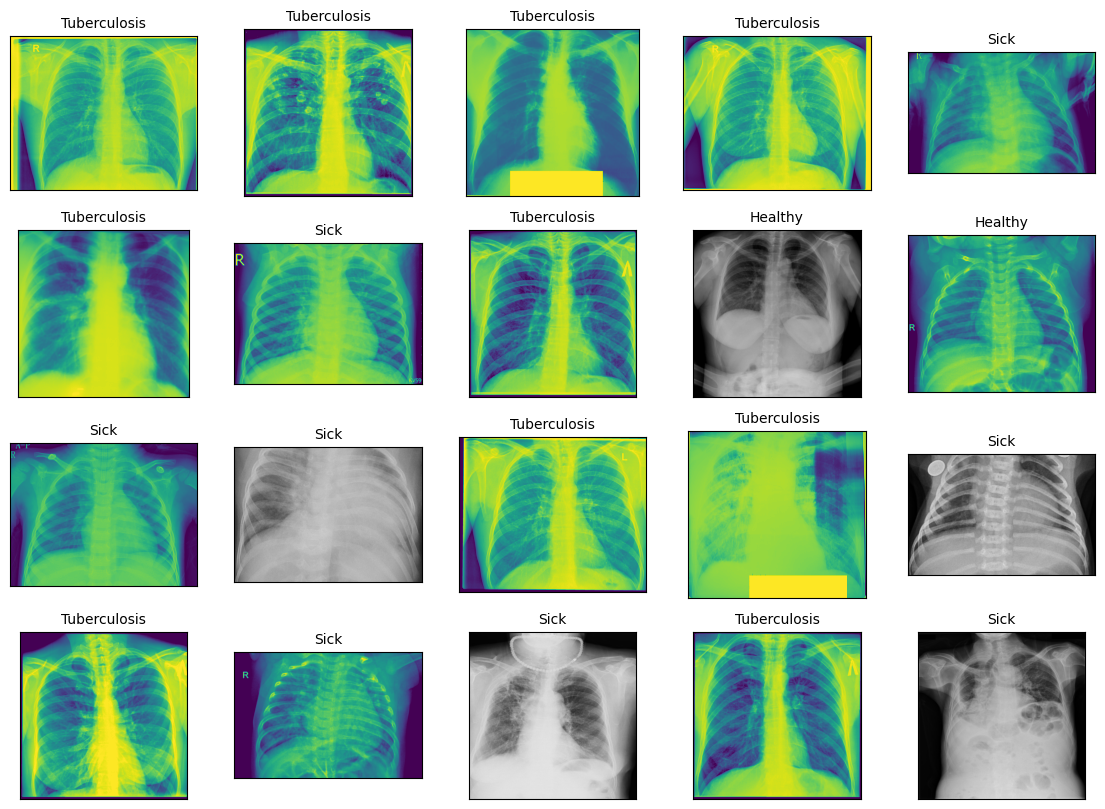

In [18]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

    
plt.show()

### **Split Dataframe into Train, Valid, and Test**

In [19]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Sick            4369
Tuberculosis    4343
Healthy         4338
Name: labels, dtype: int64
Healthy         500
Tuberculosis    482
Sick            468
Name: labels, dtype: int64
Tuberculosis    263
Sick            251
Healthy         250
Name: labels, dtype: int64


### **ImageDataGenerator**

In [20]:
target_size=(512, 512)
batch_size=16

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')

Found 13047 validated image filenames belonging to 3 classes.
Found 1450 validated image filenames belonging to 3 classes.
Found 764 validated image filenames belonging to 3 classes.


/Users/user/projects/TB/bounding-box-lung-disease-detection/env/lib/python3.10/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 3 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


### DenseNet-121 model

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Add
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, concatenate, Layer
from tensorflow.keras.activations import sigmoid, softmax
import tensorflow.keras.backend as K


In [5]:
class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd = self.add_weight(name='lambda',
                                     shape=(3, 1),  # Adding one dimension for broadcasting
                                     initializer=tf.keras.initializers.Constant(1/3),  # Try also 'ones' and 'uniform'
                                     trainable=True)
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        h1, h2, h3 = x
        return self.lambd[0] * h1 + self.lambd[1] * h2 +  self.lambd[2] * h3

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [6]:
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters, block, kernel=1,strides=1):
        x = BatchNormalization(name="BN-"+block)(x)
        x = ReLU(name="relu-"+block)(x)
        x = Conv2D(filters, kernel, strides=strides, padding = 'same', name="conv-"+block)(x)
        return x
    
    def dense_block(x, repetition):
        for i in range(repetition):
            y = bn_rl_conv(x, 4*filters,str(repetition)+"-1-"+str(i))
            y = bn_rl_conv(y, filters, str(repetition)+"-2-"+str(i), kernel=3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x,block,pooling=True):
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2, block)
        if pooling:
            x = AvgPool2D(2, strides = 2, padding = 'same', name='avgp_'+str(block))(x)
        return x
     
    input = Input(input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    b_0 = dense_block(x, 6)
    b_0 = transition_layer(b_0,'tran-'+str(6))

    b_1 = dense_block(b_0, 12)
    b_1 = transition_layer(b_1,'tran-'+str(12))
    ex_1 = GlobalAveragePooling2D(name="GAP1")(b_1)
    ex_1 = Dense(n_classes, name='Dense1')(ex_1)

    b_2 = dense_block(b_1, 24)
    b_2= transition_layer(b_2,'tran-'+str(24))
    ex_2 = GlobalAveragePooling2D(name="GAP2")(b_2)
    ex_2 = Dense(n_classes, name='Dense2')(ex_2)

    b_3 = dense_block(b_2, 16)
    b_3 = transition_layer(b_3,'tran-'+str(16),pooling=False)
    ex_3 = GlobalAveragePooling2D(name="GAP3")(b_3)
    ex_3 = Dense(n_classes,name='Dense3')(ex_3)

    weighted_sum = ConvexCombination()([ex_1, ex_2, ex_3])
    classification_output = sigmoid(weighted_sum) 

    model = Model(input, classification_output)
    return model
input_shape = 512, 512, 3
n_classes = 3
model = densenet(input_shape,n_classes)


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

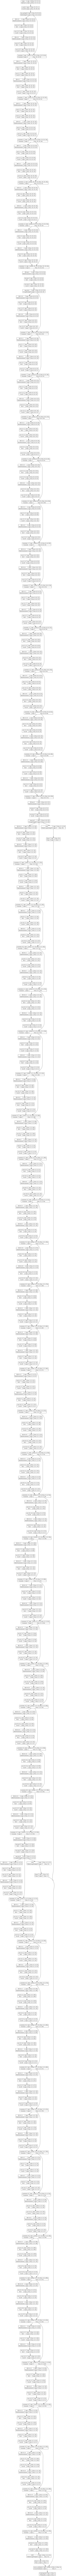

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [7]:
lr=0.0001
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=lr), 
    metrics=['accuracy'])

/Users/user/projects/TB/bounding-box-lung-disease-detection/env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Custom callback

In [28]:
patience = 2
stop_patience = 5
factor = 0.2

callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(
        "classify_model.h5", monitor='val_loss', save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(
        patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

### Training

In [29]:
epochs = 30
history = model.fit(train_gen, 
    validation_data=valid_gen, 
    epochs=epochs, 
    callbacks=callbacks, 
    verbose=1)

Epoch 1/30


2023-02-23 11:22:59.769181: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


816/816 [==============================] - 1900s 2s/step - loss: 0.3294 - accuracy: 0.8790 - val_loss: 0.9901 - val_accuracy: 0.6269 - lr: 1.0000e-04
Epoch 2/30
816/816 [==============================] - 1877s 2s/step - loss: 0.2084 - accuracy: 0.9273 - val_loss: 2.0136 - val_accuracy: 0.5972 - lr: 1.0000e-04
Epoch 3/30
816/816 [==============================] - 3506s 4s/step - loss: 0.1747 - accuracy: 0.9367 - val_loss: 0.3603 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 4/30
816/816 [==============================] - 1801s 2s/step - loss: 0.1508 - accuracy: 0.9497 - val_loss: 1.0850 - val_accuracy: 0.6883 - lr: 1.0000e-04
Epoch 5/30
816/816 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9522
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
816/816 [==============================] - 1878s 2s/step - loss: 0.1364 - accuracy: 0.9522 - val_loss: 0.4099 - val_accuracy: 0.8193 - lr: 1.0000e-04
Epoch 6/30
816/816 [========================

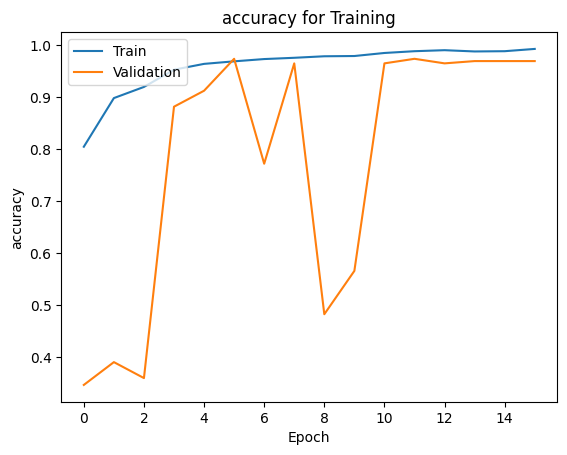

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy for Training')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()

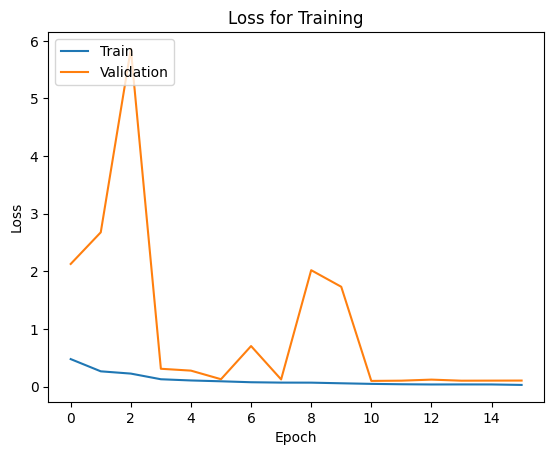

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()

In [6]:
model.evaluate(test_gen)

NameError: name 'test_gen' is not defined

In [9]:
model.load_weights('classify_model.h5')

In [10]:
def cam(img_array,conv_layer, output_layer):
    class_weights = model.get_layer(output_layer).get_weights()[0]

    print('shape of the weight is {}'.format(class_weights.shape))
    get_output = K.function(
                    [model.input], 
                    [model.get_layer(conv_layer).output, model.output])

    [conv_outputs, predictions] = get_output([img_array])
    cls = np.argmax(predictions)
    print('predictions class',  cls, predictions)
    conv_outputs = conv_outputs[0, :, :, :]
    print("shape of the convolutional layer is {}".format(conv_outputs.shape))
    
    #Create the class activation map.
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, cls]):
            cam += w * conv_outputs[:, :, i]
    cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    return cam.numpy()

In [12]:
def get_sc(fk,wk):
    sc = 0
    sum_fk = np.expand_dims(fk.sum(axis=0).sum(axis=0), axis=1)
    sc = np.matmul(np.transpose(wk,(1,0)),sum_fk)
    return np.squeeze(sc)


In [32]:
def crm(img_array,conv_layer, output_layer):
    class_weights = model.get_layer(output_layer).get_weights()[0]
    get_output = K.function(
                    [model.input], 
                    [model.get_layer(conv_layer).output, model.output])

    [conv_outputs, predictions] = get_output([img_array])
    cls = np.argmax(predictions)
    
    fk = conv_outputs[0, :, :, :]
    wk = np.expand_dims(class_weights[:, cls], axis=1)
    print(fk.shape, wk.shape)

    importance = np.zeros(fk.shape)
    sc = get_sc(fk,wk)

    for k in range(fk.shape[2]):
        for j in range(fk.shape[1]):
            for i in range(fk.shape[0]):
                temp = fk[i,j,k]
                fk[i,j,k] = 0
                importance[i,j,k] = np.power(sc - get_sc(fk,wk),2)
                fk[i,j,k] = temp
    
    importance = importance.sum(axis=-1)
    importance = (importance-importance.min())/importance.max()
    
    return importance

In [14]:
def resize_cam(heatmap, shape=(512,512)):
    heatmap = cv2.resize(heatmap, (512,512), interpolation = cv2.INTER_AREA)
    return heatmap

In [52]:
def generate_heatmap(heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_VIRIDIS)
    return heatmap

In [16]:
img = plt.imread('../../data/TBNTBN/test/NTB/person103_bacteria_490.jpeg')
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = np.expand_dims(img,0)
print(img.shape)

(1, 512, 512, 3)


In [62]:
layers = [('avgp_tran-12','Dense1'),('avgp_tran-24','Dense2'),('conv-tran-16','Dense3')]
heatmaps=[]
for layer in layers:
    heatmap = crm(img,layer[0],layer[1])
    resized_heatmap = resize_cam(heatmap)
    heatmaps.append(resized_heatmap)

(32, 32, 256) (256, 1)
(16, 16, 512) (512, 1)
(16, 16, 512) (512, 1)


maximum 0.8511408303495365
(512, 512, 3)


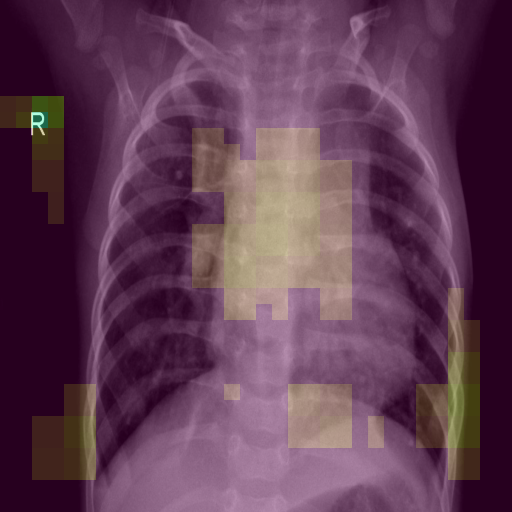

In [66]:
block_weights = model.get_layer('convex_combination').get_weights()[0]
weighted_sum_heatmap = np.zeros((512,512))
for i,weight in enumerate(block_weights):
    weighted_sum_heatmap += weight * heatmaps[i]
print('maximum', weighted_sum_heatmap.max())
weighted_sum_heatmap = np.where(weighted_sum_heatmap>0.2, weighted_sum_heatmap,0) 
final_heatmap = generate_heatmap(weighted_sum_heatmap)
alpha=0.8
img_array = np.squeeze(img)
superimposed_img = final_heatmap * alpha + img_array
print(superimposed_img.shape)
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

display(superimposed_img)
# plt.imshow(superimposed_img)